<a href="https://colab.research.google.com/github/Dz298/bitcoin-predict-sentiment/blob/main/bitcoin_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [1]:
pip install 'gast==0.2.2'

  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=8890aa96f9b44c9844899c6544f7fa09af19568109da9e20caf4b9e783662318
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [2]:
pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3MB 30.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=e87478cb3382a0c1ba093a5a2fb87673972c03309b78d27cb4384e496d6b72db
  Stored in directory: /tmp/pip-ephem-wheel-cache-ruqpfgwf/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Mount Drive to Access Files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Packages

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import glob
import os
import math
from IPython import display

import datetime
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
from matplotlib import cm
%matplotlib inline

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


# Import Tweets and Bitcoin Price



In [5]:
# import tweets along with sentiment polarity
path =  r'/content/drive/My Drive/Colab Notebooks/CS 4701/tweet_sentiment_data'   #  Path
data_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

daily_tweets = (pd.read_csv(f) for f in data_files)
tweet_data   = pd.concat(daily_tweets, ignore_index=True)
tweet_data.head()

,id,permalink,username,text,date,polarity,pos_w,neu_w,neg_w
0,1004150849935945729,https://twitter.com/WorldCoinIndex/status/1004...,WorldCoinIndex,Bitcoin price index https://t.co/o7UcHJUhC6 #U...,2018-06-05,0.0000,0.000,1.000,0.0
1,1004150843657150465,https://twitter.com/ricnnobre/status/100415084...,ricnnobre,#PERA #Payera #blockchain #tokensale #cryptocu...,2018-06-05,0.0000,0.000,1.000,0.0
2,1004150837566889984,https://twitter.com/shannongaylejoy/status/100...,shannongaylejoy,What an inspiration @dieguito is! On today's p...,2018-06-05,0.7088,0.179,0.821,0.0
3,1004150832017780736,https://twitter.com/xbtmoney/status/1004150832...,xbtmoney,Judge Reopens Cryptsy Customer Class Action Ag...,2018-06-05,0.0000,0.000,1.000,0.0
4,1004150786870243328,https://twitter.com/decoin_io/status/100415078...,decoin_io,Good day Decoin Community!\n\nOur Pre sale sta...,2018-06-05,0.9344,0.336,0.664,0.0


In [6]:
tweet_data.to_feather("/content/drive/My Drive/Colab Notebooks/CS 4701/tweet_data.ftr")

In [11]:
tweet_data = pd.read_feather("/content/drive/My Drive/Colab Notebooks/CS 4701/tweet_data.ftr")
tweet_data.head()

,id,permalink,username,text,date,polarity,pos_w,neu_w,neg_w
0,1004150849935945729,https://twitter.com/WorldCoinIndex/status/1004...,WorldCoinIndex,Bitcoin price index https://t.co/o7UcHJUhC6 #U...,2018-06-05,0.0000,0.000,1.000,0.0
1,1004150843657150465,https://twitter.com/ricnnobre/status/100415084...,ricnnobre,#PERA #Payera #blockchain #tokensale #cryptocu...,2018-06-05,0.0000,0.000,1.000,0.0
2,1004150837566889984,https://twitter.com/shannongaylejoy/status/100...,shannongaylejoy,What an inspiration @dieguito is! On today's p...,2018-06-05,0.7088,0.179,0.821,0.0
3,1004150832017780736,https://twitter.com/xbtmoney/status/1004150832...,xbtmoney,Judge Reopens Cryptsy Customer Class Action Ag...,2018-06-05,0.0000,0.000,1.000,0.0
4,1004150786870243328,https://twitter.com/decoin_io/status/100415078...,decoin_io,Good day Decoin Community!\n\nOur Pre sale sta...,2018-06-05,0.9344,0.336,0.664,0.0


In [12]:
tweet_data = tweet_data.iloc[:,[4,5]]
tweet_data.head()

,date,polarity
0,2018-06-05,0.0000
1,2018-06-05,0.0000
2,2018-06-05,0.7088
3,2018-06-05,0.0000
4,2018-06-05,0.9344


In [13]:
# import bitcoin price
btc = yf.download("BTC-USD", start="2016-03-25", end="2021-02-28")
btc_data = btc['Close'].to_frame()
btc_data.reset_index(level=0, inplace=True)
btc_data.columns = ['date', 'close']
btc_data.head()

[*********************100%***********************]  1 of 1 completed


,date,close
0,2016-03-25,417.177002
1,2016-03-26,417.945007
2,2016-03-27,426.765015
3,2016-03-28,424.230988
4,2016-03-29,416.515991


In [14]:
tweet_data["is_positive"] = np.where(tweet_data["polarity"] > 0, 1, 0)
tweet_data.head()

,date,polarity,is_positive
0,2018-06-05,0.0000,0
1,2018-06-05,0.0000,0
2,2018-06-05,0.7088,1
3,2018-06-05,0.0000,0
4,2018-06-05,0.9344,1


In [16]:
tweet_data_daily = tweet_data.groupby(pd.Grouper(key='date', sort=True)).sum()
tweet_data_daily.reset_index(level=0, inplace=True)
tweet_data_daily.head()

,date,polarity,is_positive
0,2016-03-25,17.4325,48
1,2016-03-26,27.9960,57
2,2016-03-27,14.2775,39
3,2016-03-28,21.5574,53
4,2016-03-29,12.7605,43


In [17]:
tweet_data_daily["date"] = tweet_data_daily["date"].astype('datetime64[ns]')
btc_data["date"] = btc_data["date"].astype('datetime64[ns]')
tweet_btc_data = btc_data.merge(tweet_data_daily, on="date")
tweet_btc_data.head()

,date,close,polarity,is_positive
0,2016-03-25,417.177002,17.4325,48
1,2016-03-26,417.945007,27.9960,57
2,2016-03-27,426.765015,14.2775,39
3,2016-03-28,424.230988,21.5574,53
4,2016-03-29,416.515991,12.7605,43


In [18]:
# Create data model
tweet_data_model = ols("""is_positive ~ close""", data=tweet_btc_data).fit()
print(tweet_data_model.summary())

                            OLS Regression Results                            
Dep. Variable:            is_positive   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     18.12
Date:                Sat, 15 May 2021   Prob (F-statistic):           2.18e-05
Time:                        22:45:42   Log-Likelihood:                -6273.9
No. Observations:                1798   AIC:                         1.255e+04
Df Residuals:                    1796   BIC:                         1.256e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.9284      0.261    122.176      0.0

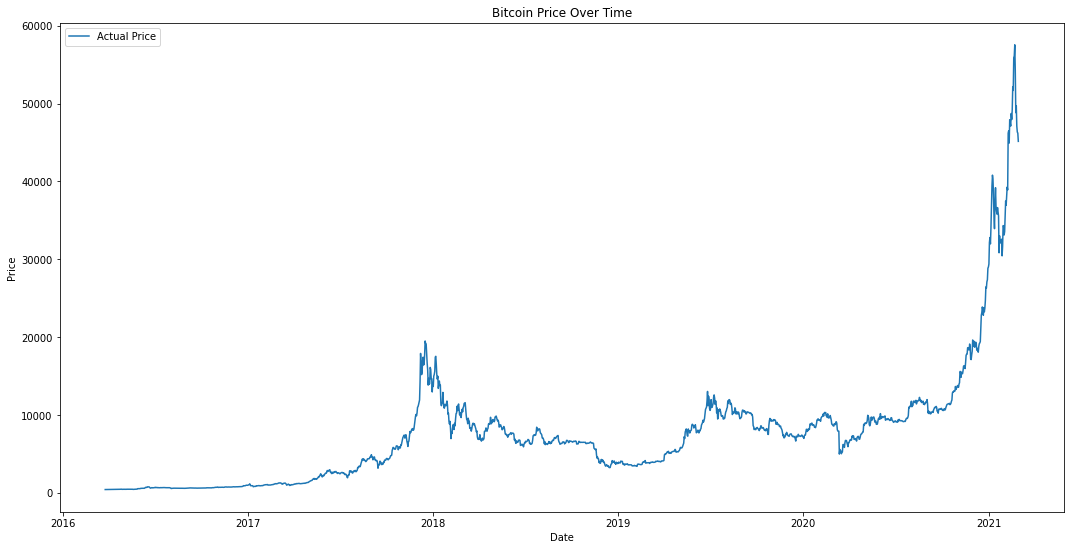

In [ ]:
# visualize bitcoin price over time 
plt.figure(figsize = (18,9))
plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Over Time')
plt.legend()

(0.0, 100.0)

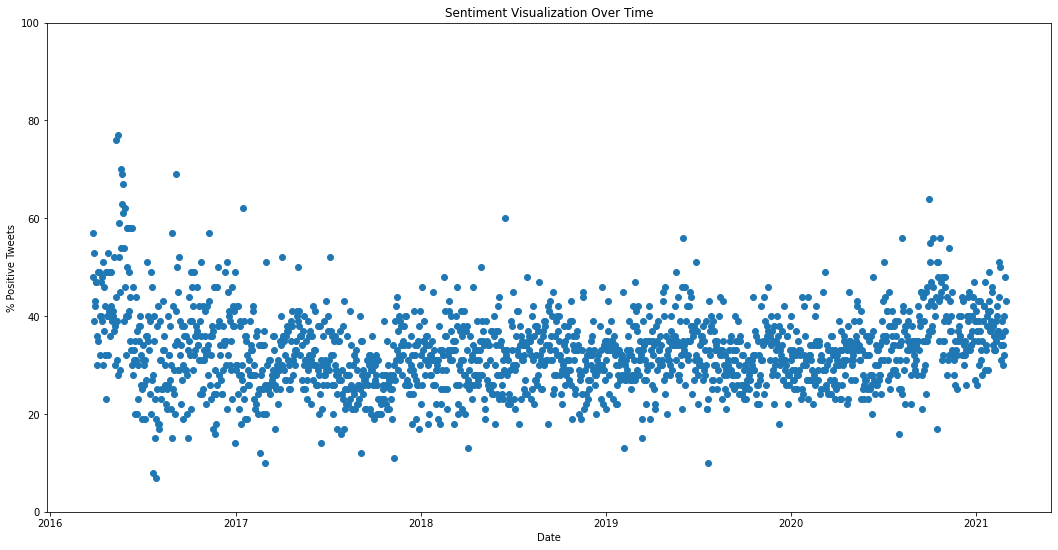

In [ ]:
# visualize tweet sentiment over time 
plt.figure(figsize = (18,9))
#is_positive = tweet_btc_data['is_positive']
#is_positive_bool = is_positive.between(is_positive.quantile(.03), is_positive.quantile(.97))
#is_positive_val = is_positive[is_positive_bool]
#dates_to_remove = tweet_btc_data['date'][~is_positive_bool].index
#date_val = tweet_btc_data['date'].drop(dates_to_remove)
#plt.plot(date_val, is_positive_val, 'o')
date_val = tweet_btc_data['date']
is_positive_val = tweet_btc_data['is_positive']
plt.plot(date_val, is_positive_val, 'o')
plt.xlabel('Date')
plt.ylabel('% Positive Tweets')
plt.title('Sentiment Visualization Over Time')
plt.ylim(0,100)

In [ ]:
current_prices = tweet_btc_data['close']
past_prices = current_prices[:len(tweet_btc_data)-1]
past_prices = np.concatenate((np.array([0]), past_prices), axis=None)
tweet_btc_data["past_price"] = past_prices
tweet_btc_data.head()

,date,close,polarity,is_positive,past_price
0,2016-03-25,417.177002,17.4325,48,0.000000
1,2016-03-26,417.945007,27.9960,57,417.177002
2,2016-03-27,426.765015,14.2775,39,417.945007
3,2016-03-28,424.230988,21.5574,53,426.765015
4,2016-03-29,416.515991,12.7605,43,424.230988


In [ ]:
def average_past_prices(df,n):
    """
    Average past prices over n days, 
    and add the average price to df as a new feature column
    Args:
      df: dataframe containing feature data   
      n: time period for averaging prices
    Returns:
      dataframe with added feature data
    """
    prices = df['close']
    average_prices = np.convolve(prices, np.ones(n), 'same') / n
    tweet_btc_data["average_prices"] = average_prices

average_past_prices(tweet_btc_data,4)
tweet_btc_data.head()

,date,close,polarity,is_positive,past_price,average_prices
0,2016-03-25,417.177002,17.4325,48,0.000000,208.780502
1,2016-03-26,417.945007,27.9960,57,417.177002,315.471756
2,2016-03-27,426.765015,14.2775,39,417.945007,421.529503
3,2016-03-28,424.230988,21.5574,53,426.765015,421.364250
4,2016-03-29,416.515991,12.7605,43,424.230988,420.582001


In [ ]:
tweet_btc_data_training = tweet_btc_data[:1500]
tweet_btc_data_test = tweet_btc_data[1500:]


# Train Model (Linear Regression)

In [ ]:
def copy_features(df):
    """
    Copies features from dataframe

    Args:
      df: dataframe containing feature data   
    Returns:
      dataframe containing the target features used for the model
    """
    # copy_features = df[["polarity","past_price"]]
    copy_features = df[["is_positive"]]
    copy = copy_features.copy()
    return copy

def copy_labels(df):
    """
    Copies target labels from dataframe

    Args:
      df: dataframe containing label data    
    Returns:
      dataframe containing the target label used for the model
    """
    copy = pd.DataFrame()
    copy["close"] = df["close"]
    return copy

In [ ]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    Args:
    input_features: The names of the numerical input features to use.
    Returns:
    A set of feature columns
    """ 
    return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [ ]:
def input_func(features, labels, batch_size=1, shuffle=False, num_epochs=None):
    """
    Input function for training model of one feature
  
    Args:
      features: dataframe of features
      labels: dataframe of labels
      batch_size: size of batch passed to the model
      shuffle: shuffle the data? (bool)
      num_epochs: # of epochs in which data is repeated. default = always repeat
    Returns:
      (features, labels) tuple for next data batch
    """
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    data = Dataset.from_tensor_slices((features,labels)) # warning: 2GB limit
    data = data.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        data = data.shuffle(buffer_size=10000)
            
    # Return the next batch of data.
    features, labels = data.make_one_shot_iterator().get_next()
    return features, labels

In [ ]:
def train_model(learning_rate, steps, batch_size, input_feature="is_positive"):
    """
    Trains a linear regression model of one feature
  
    Args:
      learning_rate: the learning rate (float)
      steps: the total number of training steps. (non-zero integer)
             consists of a forward and backward pass using a single batch.
      batch_size: the size of the batch passed to the model (non-zero integer)
      input_feature: specifying the column from `tweet_btc_data`
                     to use as an input feature (non-zero integer)
    """
    periods = 20
    steps_per_period = steps / periods
    
    input_feature_data = tweet_btc_data_training[[input_feature]]
    label = "close"
    targets = tweet_btc_data_training[label]
    
    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(input_feature)]
    
    # Create input functions.
    training_input_fn = lambda:input_func(input_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: input_func(input_feature_data, targets, num_epochs=1, shuffle=False)
    
    # Create a linear regressor object.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    
    linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=optimizer
    )
    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(label)
    plt.xlabel(input_feature)
    sample = tweet_btc_data.sample(n=300)
    plt.scatter(sample[input_feature], sample[label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
          input_fn=training_input_fn,
          steps=steps_per_period
        )
        
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss.
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                  sample[input_feature].max()),
                           sample[input_feature].min())
        
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data.
    calibration_data_final = pd.DataFrame()
    calibration_data_final["predictions"] = pd.Series(predictions)
    calibration_data_final["targets"] = pd.Series(targets)
    display.display(calibration_data_final.describe())

    plt.figure(figsize = (18,9))
    plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], color='blue', label='Actual Price')
    plt.plot(tweet_btc_data_training['date'], predictions, color='red', label='Training Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Bitcoin Price Over Time')
    plt.legend()
    
    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
    
    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 4192.14
  period 01 : 4191.63
  period 02 : 4191.13
  period 03 : 4190.65
  period 04 : 4190.17
  period 05 : 4189.71
  period 06 : 4189.25
  period 07 : 4188.79
  period 08 : 4188.35
  period 09 : 4187.90
  period 10 : 4187.47
  period 11 : 4187.03
  period 12 : 4186.60
  period 13 : 4186.18
  period 14 : 4185.76
  period 15 : 4185.34
  period 16 : 4184.93
  period 17 : 4184.52
  period 18 : 4184.11
  period 19 : 4183.70
Model training finished.


,predictions,targets
count,1500.000000,1500.000000
mean,5172.243164,5391.820773
std,1254.253052,3842.659268
min,1220.179321,414.816010
25%,4374.425781,1192.555023
50%,5005.274902,5731.969971
75%,5793.836426,8192.236328
max,12260.041992,19497.400391


Final RMSE (on training data): 4183.70


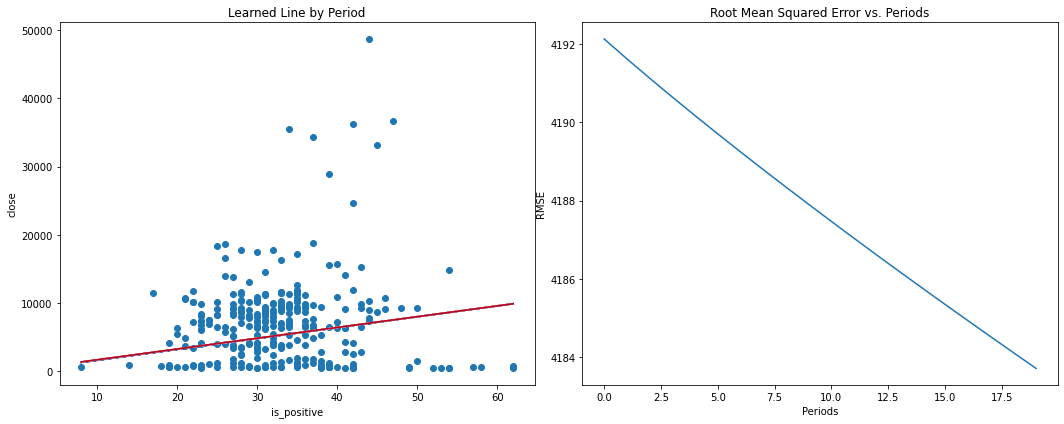

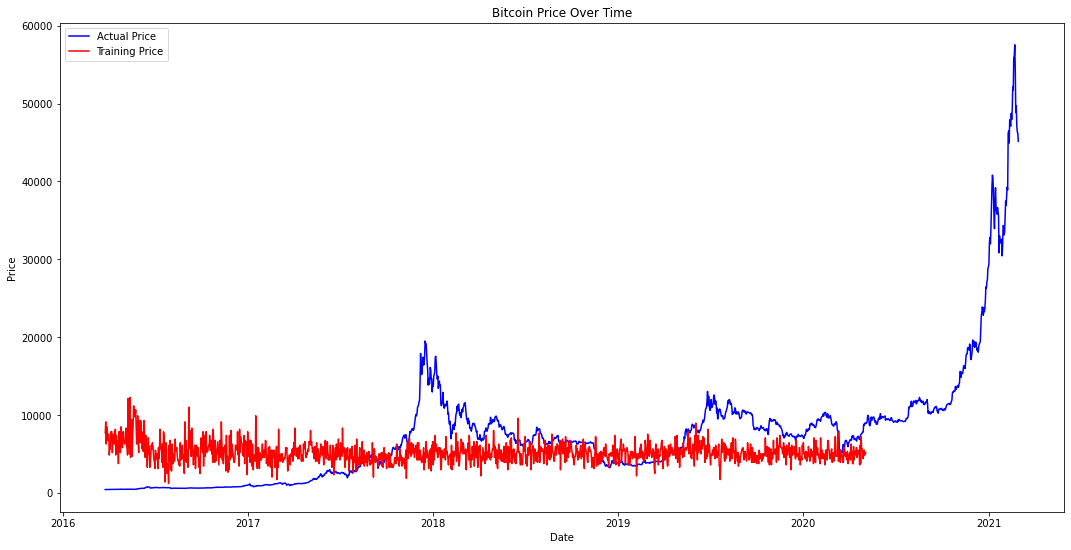

In [ ]:
linear_regressor = train_model(
    learning_rate=0.25,
    steps=10000,
    batch_size=150)

In [ ]:
test_examples = copy_features(tweet_btc_data_test)
test_targets = copy_labels(tweet_btc_data_test)

predict_test_input_fn = lambda: input_func(
    test_examples, 
    test_targets['close'], 
    num_epochs=1, 
    shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))
print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 17242.97


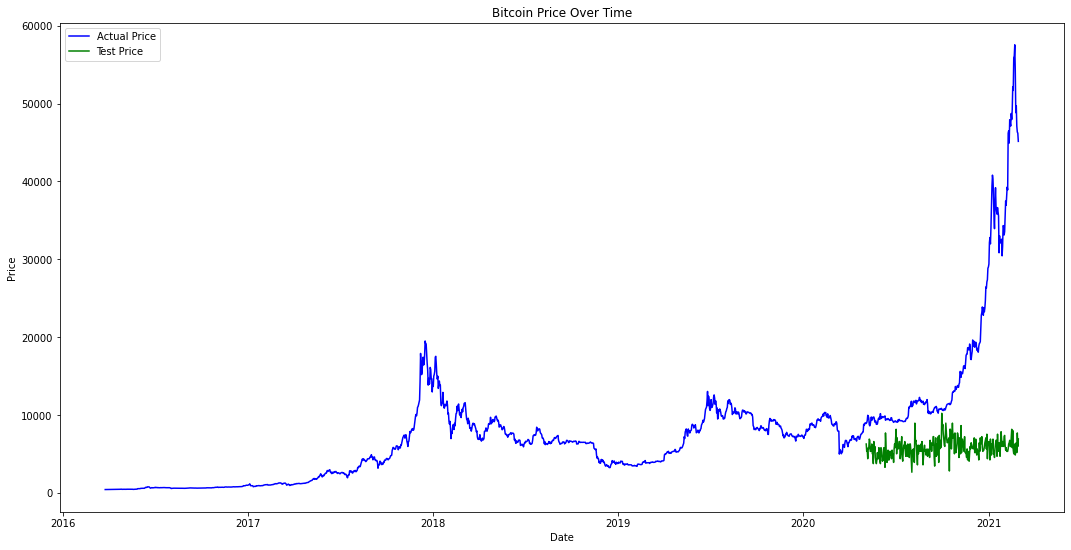

In [ ]:
  plt.figure(figsize = (18,9))
  plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], color='blue', label='Actual Price')
  plt.plot(tweet_btc_data_test['date'], test_predictions, color='green', label='Test Price')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Bitcoin Price Over Time')
  plt.legend()

# Train Model (Deep Neural Network)


In [ ]:
def DNN_copy_features(df):
    """
    Copies features from dataframe

    Args:
      df: dataframe containing feature data   
    Returns:
      dataframe containing the target features used for the model
    """
    copy_features = df[["is_positive","average_prices"]]
    # copy_features = df[["is_positive"]]
    copy = copy_features.copy()
    return copy

In [ ]:
# training validation split
training_features = DNN_copy_features(tweet_btc_data_training.head(1200))
training_targets = copy_labels(tweet_btc_data.head(1200))

validation_features = DNN_copy_features(tweet_btc_data_training[1200:])
validation_targets =  copy_labels(tweet_btc_data_training[1200:])

print("Training features summary:")
display.display(training_features.describe())
print("Training targets summary:")
display.display(training_targets.describe())

print("Validation features summary:")
display.display(validation_features.describe())

print("Validation targets summary:")
display.display(validation_targets.describe())

Training features summary:


,is_positive,average_prices
count,1200.000000,1200.000000
mean,32.280000,4565.606532
std,8.444783,3801.210317
min,7.000000,208.780502
25%,27.000000,931.782818
50%,32.000000,3919.071625
75%,37.000000,6887.456818
max,77.000000,18882.274902


Training targets summary:


,close
count,1200.000000
mean,4570.240170
std,3811.441229
min,414.816010
25%,921.935257
50%,3907.936768
75%,6846.632446
max,19497.400391


Validation features summary:


,is_positive,average_prices
count,300.000000,300.000000
mean,31.173333,8681.437689
std,5.488506,1470.667674
min,10.000000,5208.197632
25%,27.000000,7365.969208
50%,31.000000,8647.252808
75%,35.000000,9904.371643
max,49.000000,12116.782471


Validation targets summary:


,close
count,300.000000
mean,8678.143184
std,1492.833736
min,4970.788086
25%,7419.818970
50%,8659.626953
75%,9858.738281
max,12573.812500


In [ ]:
def train_nn_regression_model(
    my_optimizer, 
    steps, 
    batch_size, 
    hidden_units, 
    training_features,
    training_targets,
    validation_features,
    validation_targets):
    """Trains a neural network regression model.
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `price_tweet_df`
          to use as input feature.
    Returns:
        A tuple (estimator, training_losses):
        estimator: the trained DNNRegressor object.
        training_losses: a list containg the training loss values taken during training.
        
  """
    periods = 10
    steps_per_period = steps / periods
    
    # Create a DNNRegressor object.
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_features),
        hidden_units=hidden_units,
        optimizer=my_optimizer
    )
    
    # Create input functions.
    training_input_fn = lambda:input_func(training_features, 
                                           training_targets['close'], 
                                           batch_size=batch_size)
    
    prediction_training_input_fn = lambda: input_func(training_features, 
                                                       training_targets['close'], 
                                                       num_epochs=1, 
                                                       shuffle=False)
    
    prediction_validation_input_fn = lambda: input_func(validation_features, 
                                                       validation_targets['close'], 
                                                       num_epochs=1, 
                                                       shuffle=False)
   
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=prediction_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = dnn_regressor.predict(input_fn=prediction_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        
        # add the loss metrics from this period to our list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")

    predictions = np.concatenate((training_predictions,validation_predictions),axis=None)

    plt.figure(figsize = (18,9))
    plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], color='blue', label='Actual Price')
    plt.plot(tweet_btc_data_training['date'], predictions, color='red', label='Training Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Bitcoin Price Over Time')
    plt.legend()

    plt.figure(figsize = (18,9))
    plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], color='blue', label='Actual Price')
    plt.plot(tweet_btc_data_training['date'], tweet_btc_data_training['close']-predictions, color='green', label='Price Difference')
    plt.xlabel('Date')
    plt.ylabel('Difference')
    plt.title('Predicted and Actual Price Difference Over Time')
    plt.legend()
    
    print("Final RMSE (on training data): %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)
    
    return dnn_regressor

## Use sentiment analysis and average past prices

Training model...
RMSE (on training data):
  period 00 : 863.41
  period 01 : 984.57
  period 02 : 1106.27
  period 03 : 1226.26
  period 04 : 1337.74
  period 05 : 1430.92
  period 06 : 1495.04
  period 07 : 1519.95
  period 08 : 1497.70
  period 09 : 1429.50
Model training finished.
Final RMSE (on training data): 1429.50
Final RMSE (on validation data): 2128.89


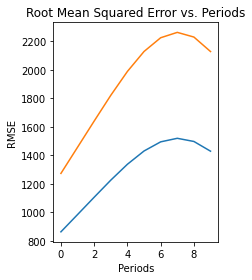

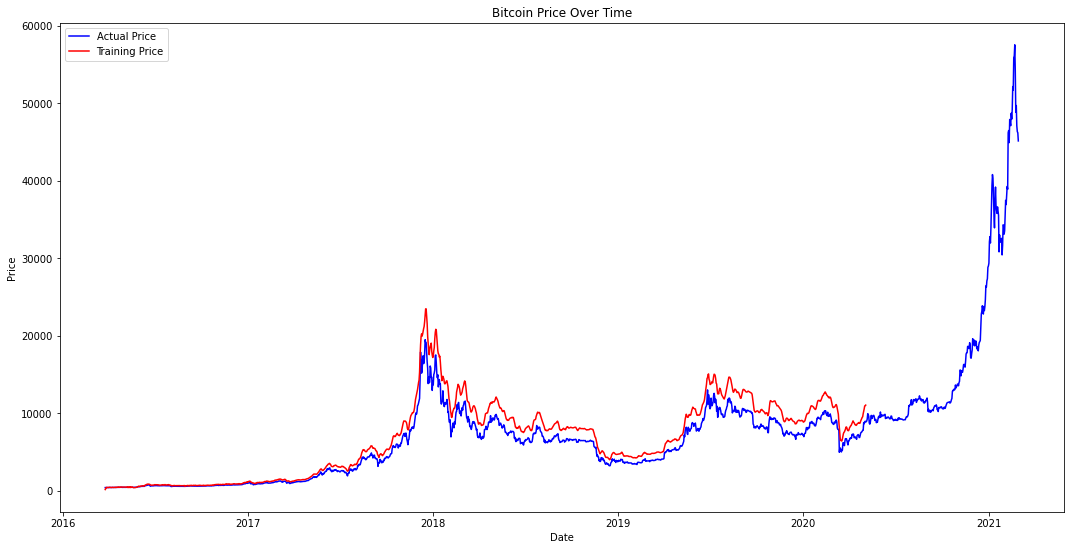

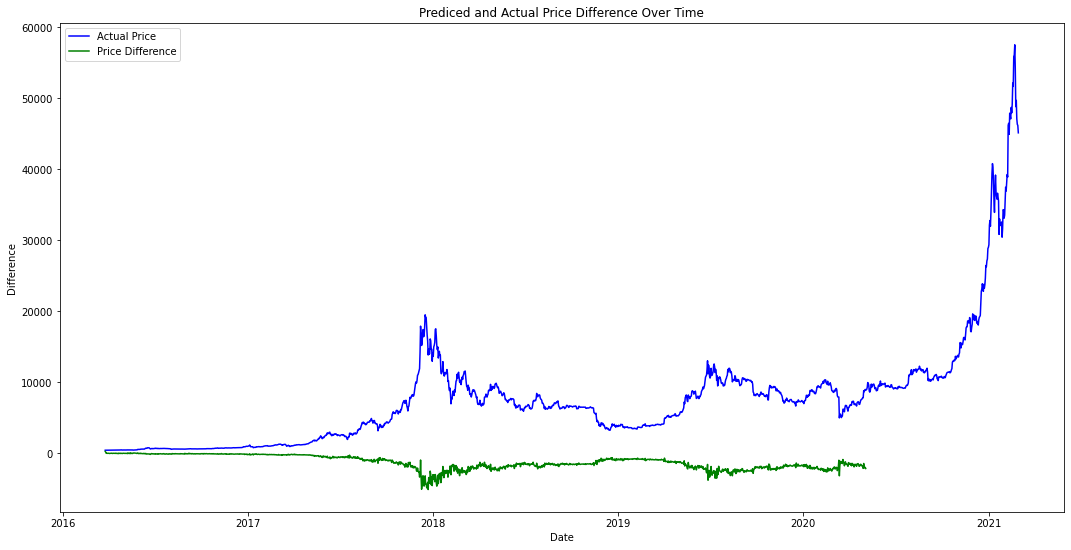

In [ ]:

dnn_regressor = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.03),
    steps=10000,
    batch_size=70,
    hidden_units=[10,10],
    training_features=training_features,
    training_targets=training_targets,
    validation_features=validation_features,
    validation_targets=validation_targets)

In [ ]:
test_examples = DNN_copy_features(tweet_btc_data_test)
test_targets = copy_labels(tweet_btc_data_test)

predict_test_input_fn = lambda: input_func(
    test_examples, 
    test_targets['close'], 
    num_epochs=1, 
    shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 5229.02


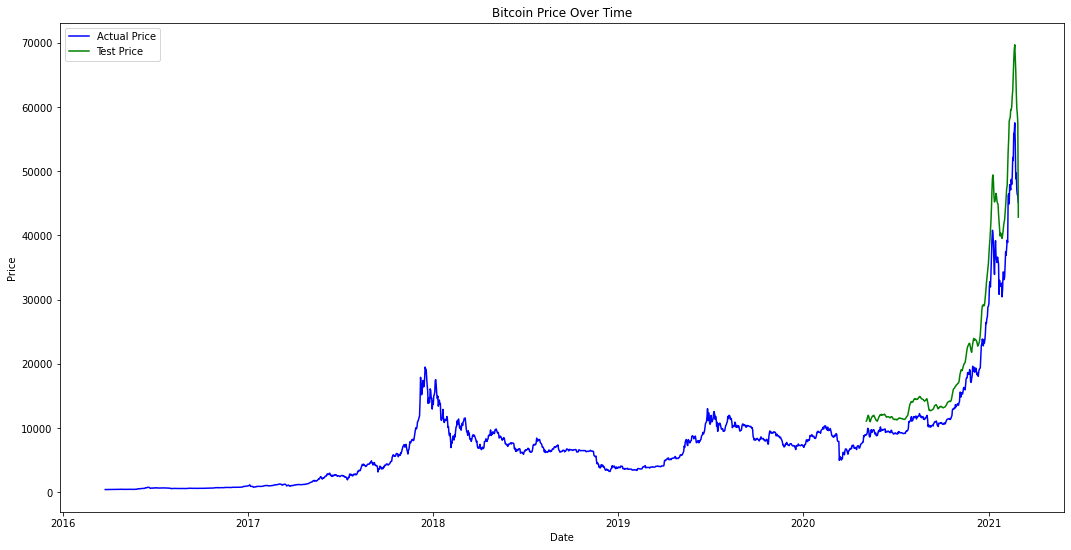

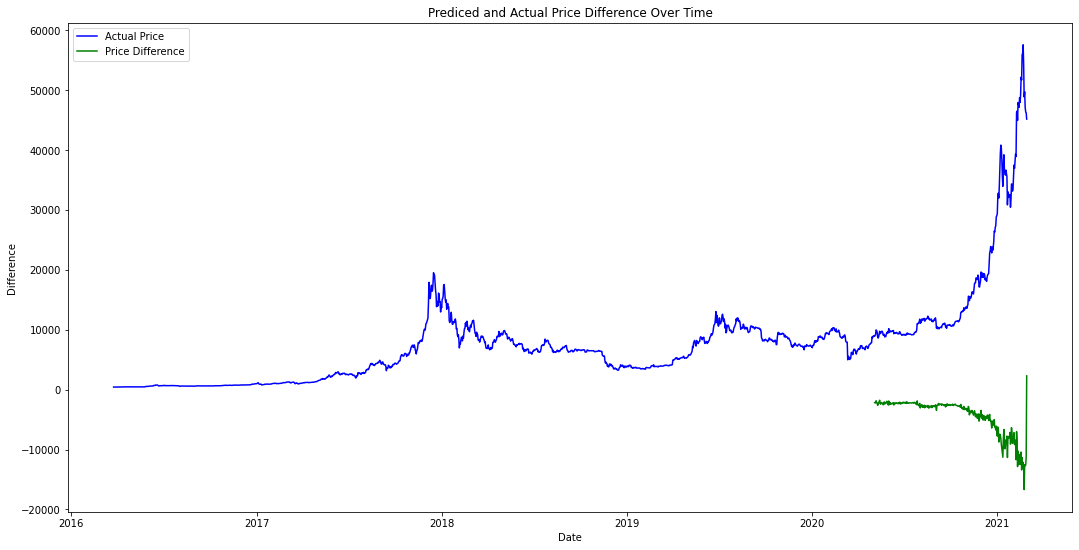

In [ ]:
  plt.figure(figsize = (18,9))
  plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], color='blue', label='Actual Price')
  plt.plot(tweet_btc_data_test['date'], test_predictions, color='green', label='Test Price')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Bitcoin Price Over Time')
  plt.legend()

  plt.figure(figsize = (18,9))
  plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], color='blue', label='Actual Price')
  plt.plot(tweet_btc_data_test['date'], tweet_btc_data_test['close']-test_predictions, color='green', label='Price Difference')
  plt.xlabel('Date')
  plt.ylabel('Difference')
  plt.title('Predicted and Actual Price Difference Over Time')
  plt.legend()

## Use past average prices only

In [ ]:
past_training_set = tweet_btc_data_training.head(1200)
past_validation_set = tweet_btc_data_training[1200:]

copy_features = past_training_set[["average_prices"]]
past_training_features = copy_features.copy()
past_training_targets = copy_labels(past_training_set)

copy_features = past_validation_set[["average_prices"]]
past_validation_features = copy_features.copy()
past_validation_targets = copy_labels(past_validation_set)


Training model...
RMSE (on training data):
  period 00 : 207.78
  period 01 : 208.05
  period 02 : 208.19
  period 03 : 208.27
  period 04 : 208.33
  period 05 : 208.37
  period 06 : 208.40
  period 07 : 208.42
  period 08 : 208.44
  period 09 : 208.45
Model training finished.
Final RMSE (on training data): 208.45
Final RMSE (on validation data): 225.79


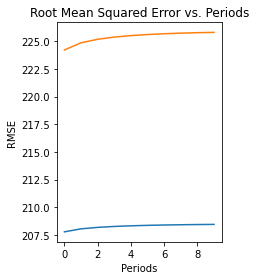

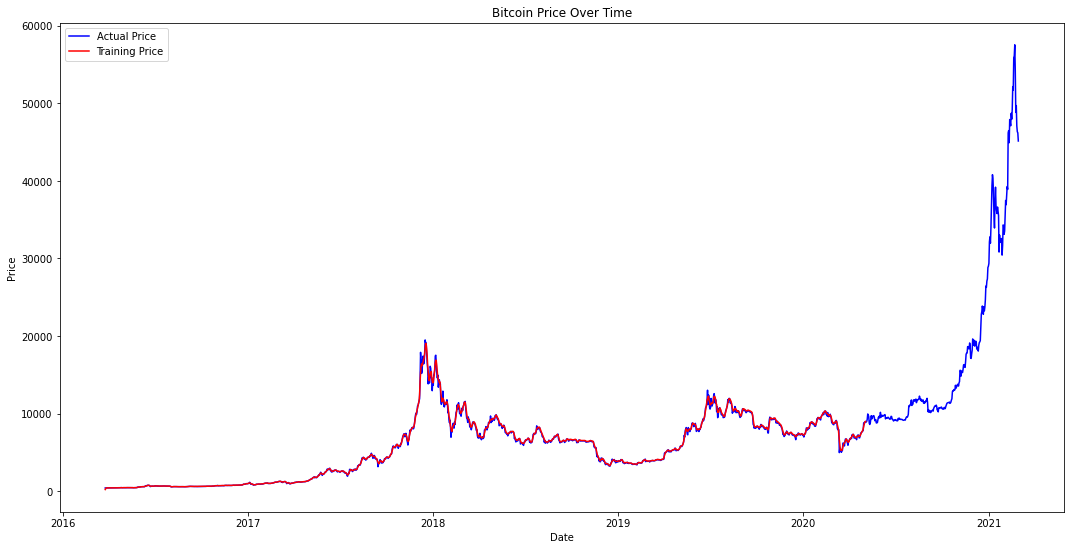

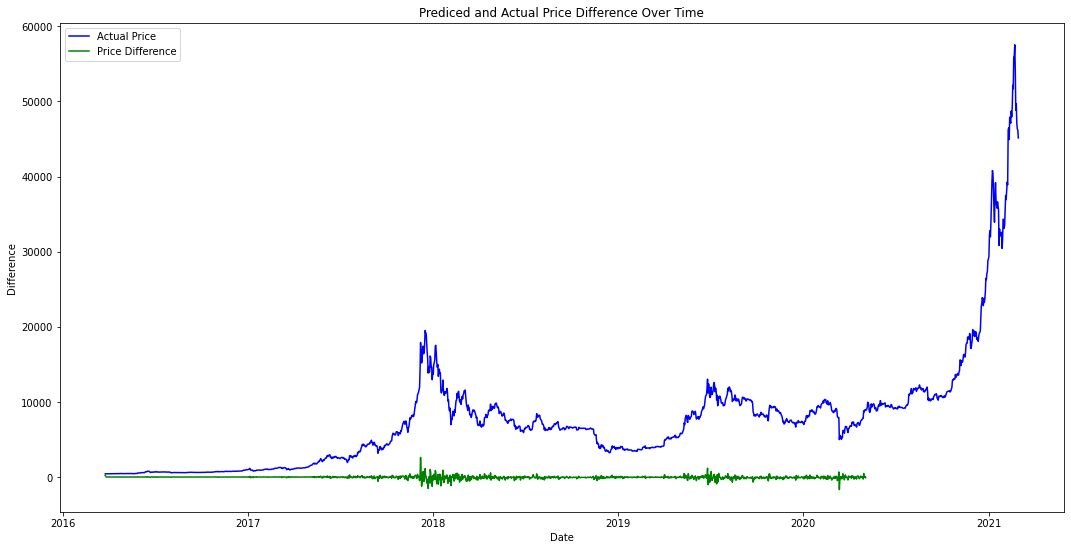

In [ ]:
past_dnn_regressor = train_nn_regression_model(
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.03),
steps=10000,
batch_size=70,
hidden_units=[10,10],
training_features=past_training_features,
training_targets=past_training_targets,
validation_features=past_validation_features,
validation_targets=past_validation_targets)


Final RMSE (on test data): 869.38


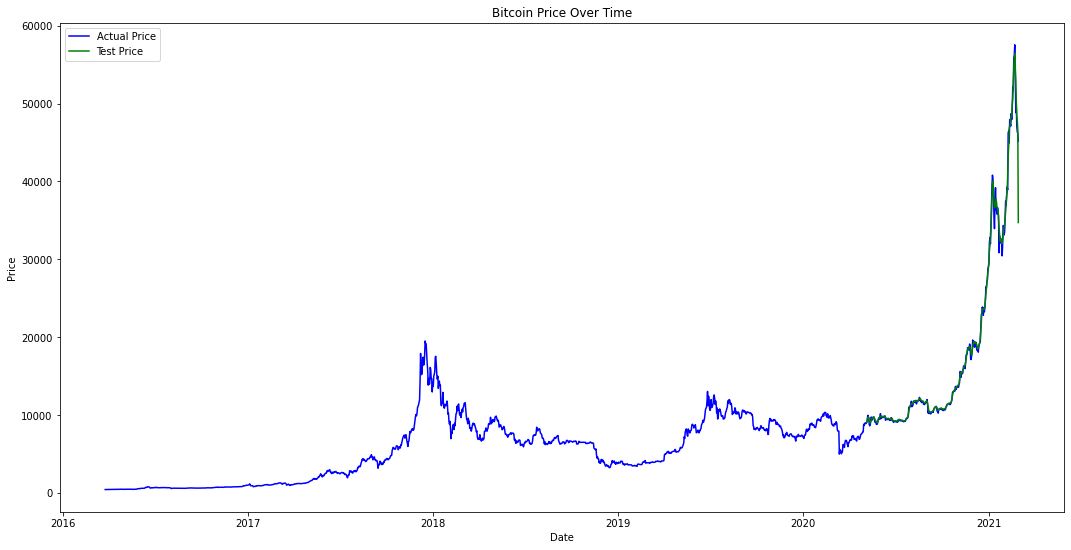

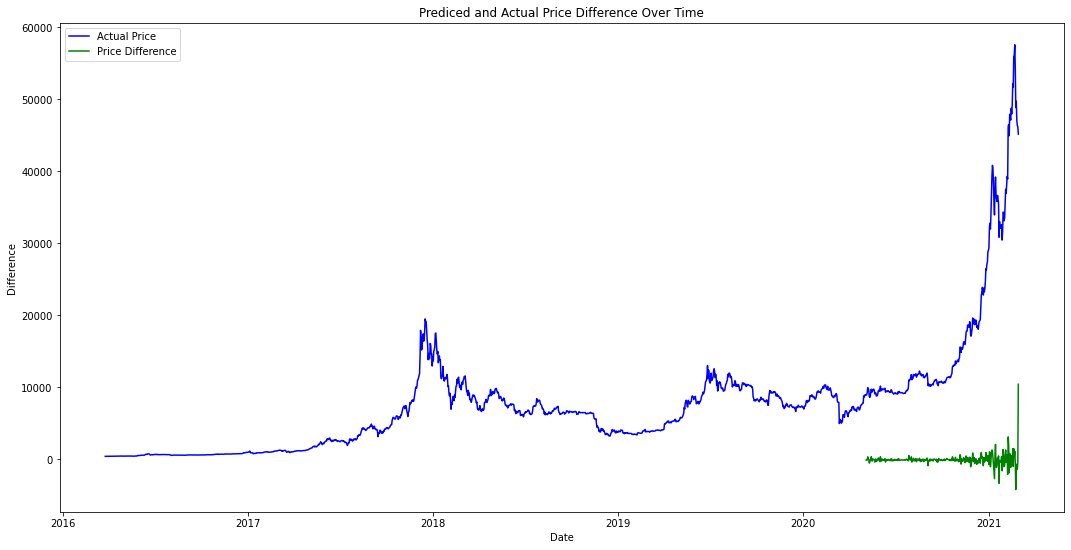

In [ ]:

copy_features = tweet_btc_data_test[["average_prices"]]
past_test_features = copy_features.copy()
past_test_targets = copy_labels(tweet_btc_data_test)

past_predict_test_input_fn = lambda: input_func(
    past_test_features, 
    past_test_targets['close'], 
    num_epochs=1, 
    shuffle=False)

past_test_predictions = past_dnn_regressor.predict(input_fn=past_predict_test_input_fn)
past_test_predictions = np.array([item['predictions'][0] for item in past_test_predictions])
past_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(past_test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % past_root_mean_squared_error)

plt.figure(figsize = (18,9))
plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], color='blue', label='Actual Price')
plt.plot(tweet_btc_data_test['date'], past_test_predictions, color='green', label='Test Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Over Time')
plt.legend()

plt.figure(figsize = (18,9))
plt.plot(tweet_btc_data['date'], tweet_btc_data['close'], color='blue', label='Actual Price')
plt.plot(tweet_btc_data_test['date'], tweet_btc_data_test['close']-past_test_predictions, color='green', label='Price Difference')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.title('Prediced and Actual Price Difference Over Time')
plt.legend()